## Compares metagene profiles of degradation factors on stable and unstable transcripts

In [1]:
import pybedtools 
import sys
import numpy as np
import pandas as pd
import os
import collections
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import glob
import itertools
import seaborn as sns

In [2]:
home_dir = "/Users/salma/Coding/cluster"
pipeline_dir = os.path.join(home_dir, 'pipeline')
analysis_dir = os.path.join(home_dir, 'data_analysis/occ_transcripts_with_halflives')
plotting_dir = '/Users/salma/Documents/plots/half_life_analysis'

In [3]:
#load the file that has the half life attributes
f = os.path.join(home_dir, "additional_files/bjoern/cerevisiae_with_halflives.txt")
anno = pd.read_table(f, sep='\t')
ORFs = anno.loc[anno['type'].isin(['ORF-T'])]

#format into bed 
ORFs = ORFs.rename(columns= {'alternative.half.lives.transcript.anno.Wild' : 'half_lives'})
ORFs = ORFs[['chr', 'type', 'name','start', 'end','half_lives', 'strand', 'length', 'id']]
ORFs.length = '.'
ORFs.id = '.'

#remove entries with NAN half lives
ORFs = ORFs[np.isfinite(ORFs['half_lives'])]

#save
ORFs.to_csv(os.path.join(home_dir, "additional_files/bjoern/cerevisiae_TIFs_halflives.gff"),\
                        index=None, sep = '\t', header = False)

ORFs[['chr','start', 'end', 'name','half_lives', 'strand']].to_csv(\
    os.path.join(home_dir, "additional_files/bjoern/cerevisiae_TIFs_halflives.bed"), \
                    index=None, sep = '\t', header = False)

ORFs_normalized = ORFs.copy()
ORFs_normalized.half_lives = ((ORFs_normalized.half_lives-min(ORFs_normalized.half_lives))/(\
                            max(ORFs_normalized.half_lives)-min(ORFs_normalized.half_lives)))

In [4]:
#divide into stable and unstable transcripts
orf_unstable = ORFs[ORFs.half_lives < ORFs.half_lives.quantile(0.25)]
orf_stable = ORFs[ORFs.half_lives > ORFs.half_lives.quantile(0.75)]

orf_unstable.to_csv(os.path.join(home_dir, "additional_files/bjoern/unstable_TIF_halflives.gff"),\
                        index=None, sep = '\t', header = False)

orf_stable.to_csv(os.path.join(home_dir, "additional_files/bjoern/stable_TIF_halflives.gff"),\
                        index=None, sep = '\t', header = False)

In [5]:

factors = ['Ccr4','Pop2','Not1', 'Caf40', 'Pan2', 'Pan3', \
           'Dcp2', 'Dcp1', 'Edc3', 'Dhh1','Edc2',  \
           'Rrp44', 'Ski8','Trf5', 'Air1','Rrp4','Ski2','Trf4', 'Rrp40', \
           'Ski7', 'Ski3','Csl4', 'Rrp6', 'Air2', 'Mtr4', 'Nrd1','Nab3',\
                         'Nmd4', 'Nam7','Nmd2', 'Upf3']

groups = [1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,5,5,5,5]
g_names = ["Deadenylation", "Decapping", "Exosome", "Nonsense surveillance", "NMD"]

direc_names  = [d for d in os.listdir(pipeline_dir) \
               if os.path.isdir(os.path.join(pipeline_dir, d))]

stable_filename   =   'stable_orf_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'
unstable_filename = 'unstable_orf_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'


In [6]:
#read profiles from mockinbird output and normalize them 

#stable transcripts
stable_profiles = list()
for d in direc_names:
    with open(os.path.join(pipeline_dir , d, 'postprocess', stable_filename)) as f:
        stable_profiles.append([float(i) for i in f.readlines()[0].split()])
        
stable_profiles = pd.DataFrame(stable_profiles, index=direc_names)        
stable_norm_profiles = stable_profiles.apply(lambda x: ((x-min(x))/(max(x)-min(x))), axis=1) 

stable_norm_profiles.index = [s.split('_')[0] for s in stable_norm_profiles.index]
stable_norm_profiles.index = [s.split('-')[0] for s in stable_norm_profiles.index]
stable_norm_profiles = stable_norm_profiles.reindex(factors)

#unstable transcripts
unstable_profiles = list()
for d in direc_names:
    with open(os.path.join(pipeline_dir , d, 'postprocess', unstable_filename)) as f:
        unstable_profiles.append([float(i) for i in f.readlines()[0].split()])
        
unstable_profiles = pd.DataFrame(unstable_profiles, index=direc_names)        
unstable_norm_profiles = unstable_profiles.apply(lambda x: ((x-min(x))/(max(x)-min(x))), axis=1) 

unstable_norm_profiles.index = [s.split('_')[0] for s in unstable_norm_profiles.index]
unstable_norm_profiles.index = [s.split('-')[0] for s in unstable_norm_profiles.index]
unstable_norm_profiles = unstable_norm_profiles.reindex(factors)

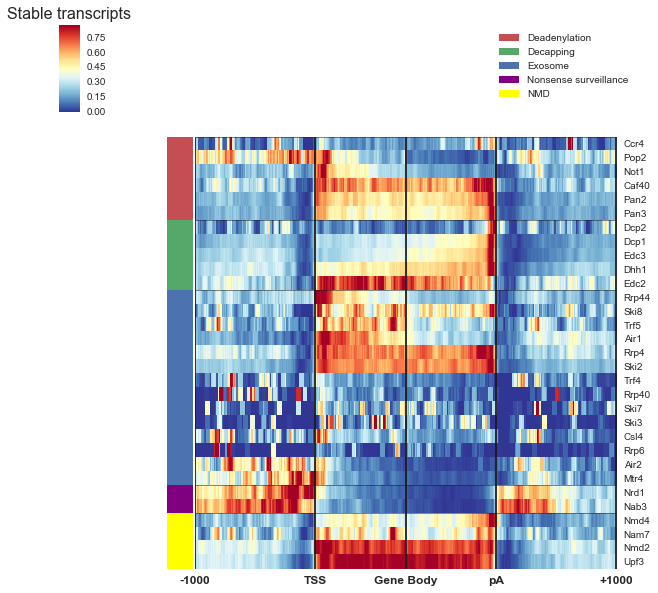

In [85]:
 #heatmap without clustering around XL sites
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)

vlinepos = [1, 1000, 1751, 2501, 3499]
hlinepos = [0,6,11,25,27,31]
labels = ['-1000', 'TSS', 'Gene Body', 'pA', '+1000']

lut = dict(zip(set(groups), ['r','g','b','purple','yellow','black','pink']))
complex_colors = [lut[x] for x in groups]


g = sns.clustermap(stable_norm_profiles, cmap="RdYlBu_r",  metric="correlation" ,robust=True,\
                  row_colors= complex_colors ,col_cluster=False, row_cluster=False, linewidths=0.0, rasterized=True)

ax = g.ax_heatmap
ax.vlines(vlinepos, *ax.get_ylim())
ax.hlines(hlinepos, *ax.get_xlim(), linewidth = 0.5)
ax.set_xticks(vlinepos)
ax.set_xticklabels(labels, rotation = 0, fontsize = 12, weight = 'bold')
a = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

for label in set(groups):
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=g_names[label-1], linewidth=0)
g.ax_col_dendrogram.legend(bbox_to_anchor=(1.05, 1), loc=1 )

plt.title('Stable transcripts', fontsize = 16)
plt.savefig(os.path.join(plotting_dir, "Metagene_by_HL","stable.pdf"))

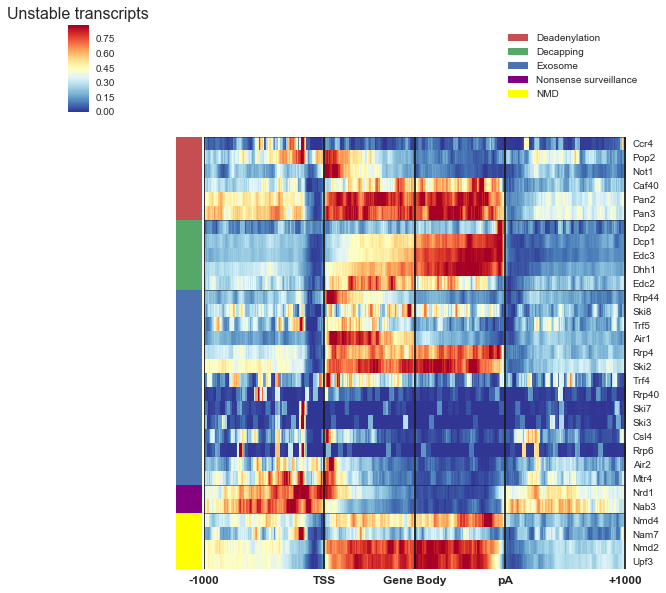

In [87]:
 #heatmap without clustering around XL sites UNSTABLE
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)

vlinepos = [1, 1000, 1751, 2501, 3499]
hlinepos = [0,6,11,25,27,31]
labels = ['-1000', 'TSS', 'Gene Body', 'pA', '+1000']

lut = dict(zip(set(groups), ['r','g','b','purple','yellow','black','pink']))
complex_colors = [lut[x] for x in groups]


g = sns.clustermap(unstable_norm_profiles, cmap="RdYlBu_r",  metric="correlation" ,robust=True,\
                  row_colors= complex_colors ,col_cluster=False, row_cluster=False, linewidths=0.0, rasterized=True)

ax = g.ax_heatmap
ax.vlines(vlinepos, *ax.get_ylim())
ax.hlines(hlinepos, *ax.get_xlim(), linewidth = 0.5)
ax.set_xticks(vlinepos)
ax.set_xticklabels(labels, rotation = 0, fontsize = 12, weight = 'bold')
a = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

for label in set(groups):
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=g_names[label-1], linewidth=0)
g.ax_col_dendrogram.legend(bbox_to_anchor=(1.05, 1), loc=1 )

plt.title('Unstable transcripts', fontsize = 16)
plt.savefig(os.path.join(plotting_dir, "Metagene_by_HL","unstable.pdf"))

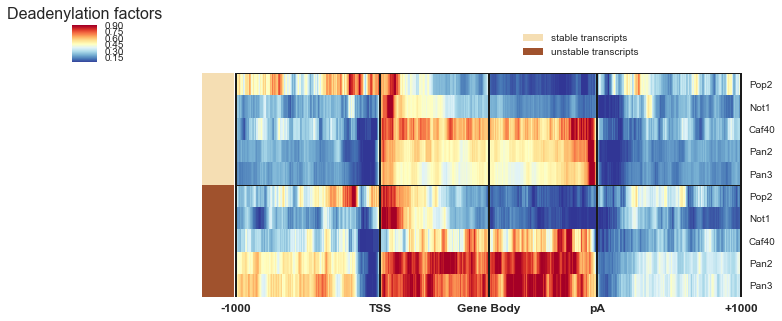

In [98]:
#DEADENYLATION
deadenylation = pd.concat([stable_norm_profiles.iloc[1:6],unstable_norm_profiles.iloc[1:6]], axis=0)

%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)

vlinepos = [1, 1000, 1751, 2501, 3499]
hlinepos = [0,5,10]
labels = ['-1000', 'TSS', 'Gene Body', 'pA', '+1000']

groups = [1,1,1,1,1,2,2,2,2,2]
g_names = ["stable transcripts", "unstable transcripts"]


lut = dict(zip(set(groups), ['wheat','sienna']))
complex_colors = [lut[x] for x in groups]

plt.figure(figsize=(5, 16))
g = sns.clustermap(deadenylation, cmap="RdYlBu_r",  metric="correlation" ,robust=True,\
                  row_colors= complex_colors ,col_cluster=False, row_cluster=False, linewidths=0.0, \
                   rasterized=True, figsize = (12,5))

ax = g.ax_heatmap
ax.vlines(vlinepos, *ax.get_ylim(), linewidth = 2)
ax.hlines(hlinepos, *ax.get_xlim(), linewidth = 1)
ax.set_xticks(vlinepos)
ax.set_xticklabels(labels, rotation = 0, fontsize = 12, weight = 'bold')
a = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

for label in set(groups):
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=g_names[label-1], linewidth=0)
g.ax_col_dendrogram.legend(bbox_to_anchor=(0.55, 1), loc=2)

plt.title('Deadenylation factors', fontsize = 16)
plt.savefig(os.path.join(plotting_dir, "Metagene_by_HL","deadenylation.pdf"))

In [96]:
from tkinter import *

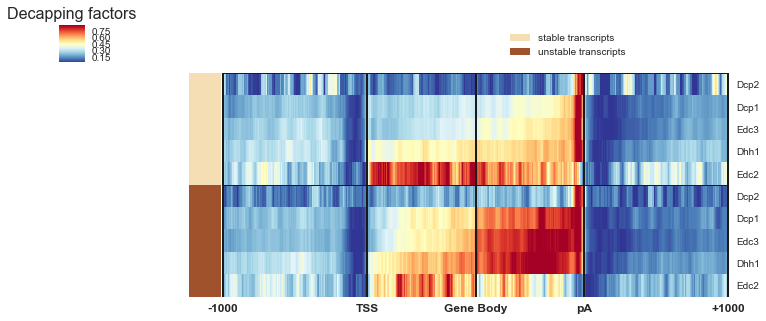

In [99]:
#DECAPPING
decapping = pd.concat([stable_norm_profiles.iloc[6:11],unstable_norm_profiles.iloc[6:11]], axis=0)

%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)

vlinepos = [1, 1000, 1751, 2501, 3499]
hlinepos = [0,5,10]
labels = ['-1000', 'TSS', 'Gene Body', 'pA', '+1000']

groups = [1,1,1,1,1,2,2,2,2,2]
g_names = ["stable transcripts", "unstable transcripts"]


lut = dict(zip(set(groups), ['wheat','sienna']))
complex_colors = [lut[x] for x in groups]

plt.figure(figsize=(5, 16))
g = sns.clustermap(decapping, cmap="RdYlBu_r",  metric="correlation" ,robust=True,\
                  row_colors= complex_colors ,col_cluster=False, row_cluster=False, linewidths=0.0, \
                   rasterized=True, figsize = (12,5))

ax = g.ax_heatmap
ax.vlines(vlinepos, *ax.get_ylim(), linewidth = 2)
ax.hlines(hlinepos, *ax.get_xlim(), linewidth = 1)
ax.set_xticks(vlinepos)
ax.set_xticklabels(labels, rotation = 0, fontsize = 12, weight = 'bold')
a = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

for label in set(groups):
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=g_names[label-1], linewidth=0)
g.ax_col_dendrogram.legend(bbox_to_anchor=(0.55, 1), loc=2)

plt.title('Decapping factors', fontsize = 16)
plt.savefig(os.path.join(plotting_dir, "Metagene_by_HL","decapping.pdf"))

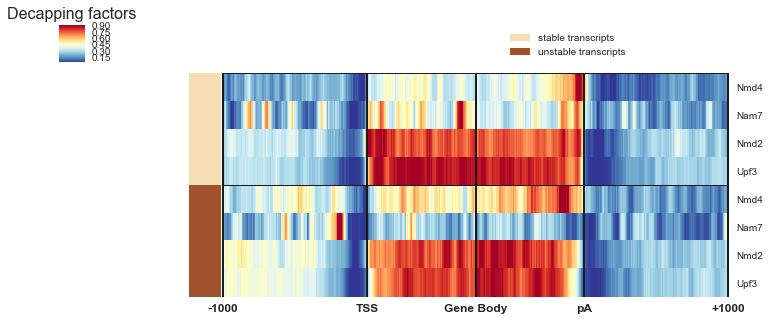

In [103]:
#NMD
nmd = pd.concat([stable_norm_profiles.iloc[27:32],unstable_norm_profiles.iloc[27:32]], axis=0)

%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)

vlinepos = [1, 1000, 1751, 2501, 3499]
hlinepos = [0,4,8]
labels = ['-1000', 'TSS', 'Gene Body', 'pA', '+1000']

groups = [1,1,1,1,2,2,2,2]
g_names = ["stable transcripts", "unstable transcripts"]


lut = dict(zip(set(groups), ['wheat','sienna']))
complex_colors = [lut[x] for x in groups]

plt.figure(figsize=(5, 16))
g = sns.clustermap(nmd, cmap="RdYlBu_r",  metric="correlation" ,robust=True,\
                  row_colors= complex_colors ,col_cluster=False, row_cluster=False, linewidths=0.0, \
                   rasterized=True, figsize = (12,5))

ax = g.ax_heatmap
ax.vlines(vlinepos, *ax.get_ylim(), linewidth = 2)
ax.hlines(hlinepos, *ax.get_xlim(), linewidth = 1)
ax.set_xticks(vlinepos)
ax.set_xticklabels(labels, rotation = 0, fontsize = 12, weight = 'bold')
a = plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

for label in set(groups):
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=g_names[label-1], linewidth=0)
g.ax_col_dendrogram.legend(bbox_to_anchor=(0.55, 1), loc=2)

plt.title('Decapping factors', fontsize = 16)
plt.savefig(os.path.join(plotting_dir, "Metagene_by_HL","NMD.pdf"))